In [13]:
import torchsde
import pytorch_lightning as pl
import torch
import torch.nn as nn
import sys
sys.path.append('../')
from torchdyn.models import * ; from torchdyn.datasets import *; from torchdyn import *

import torchsde


NOISE_TYPES = (
    'general',
    'diagonal',
    'scalar',
    'additive'
)

In [14]:
from torchsde.core.methods import EulerDiagonal

In [15]:
sde.fnfe, sde.gnfe = 0, 0
x0 = torch.rand(4, 2).to(device)
ts = torch.linspace(0, 1, 10)
bm = torchsde.brownian.brownian_path.BrownianPath(t0=ts[0], w0=torch.zeros_like(x0).cpu())
sde_shit = torchsde.core.base_sde.ForwardSDEIto(sde)
solver = EulerDiagonal(sde_shit, bm=bm, y0=(x0,), adaptive=False, dt=1, rtol=1e-3, atol=1e-3, dt_min=1e-4, options={})

In [16]:
a = solver.step(0, y0=x0, dt=0.1)

In [17]:
sde.gnfe

1

In [18]:
# data 
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')  
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [19]:
class SDEFunc(nn.Module):
    def __init__(self, f, g, order=1):
        super().__init__()  
        self.order, self.intloss, self.sensitivity = order, None, None
        self.f_func, self.g_func = f, g

    def forward(self, s, x):
        pass
    
    def f(self, s, x):
        self.f_func(x)
    
    def g(self, s, x):
        self.g_func(x)

In [20]:
def sdeint(sde, y0, ts, bm=None, logqp=False, method='srk', adaptive=False, rtol=1e-6, atol=1e-5, dt_min=1e-4,
           options=None, names=None):
    dt = ts[1] - ts[0]
    dt = 1
    return torchsde.sdeint(sde, y0, ts, bm=None, logqp=False, method='srk', dt=dt, adaptive=False, rtol=1e-6, atol=1e-5, dt_min=1e-4,
                           options=None, names=None)

In [93]:
class NeuralSDE(pl.LightningModule):
    def __init__(self, drift_func, 
                 diffusion_func, 
                 noise_type='scalar', 
                 order=1,
                 sensitivity='autograd',
                 s_span=torch.linspace(0, 1, 2),
                 solver='srk',
                 atol=1e-4,
                 rtol=1e-4,
                 intloss=None):
        
        super().__init__()
        self.defunc = SDEFunc(f, g)
        self.noise_type = noise_type
        self.sde_type = 'ito'
        
        self.rtol, self.atol = rtol, atol
        self.solver, self.s_span = solver, s_span
        
        self.fnfe, self.gnfe = 0, 0
        
    def f(self, s, x):
        self.fnfe += 1
        return self.defunc.f_func(x)
    
    def g(self, s, x):
        self.gnfe += 1
        g = self.defunc.g_func(x)
        n = g.shape[1]
        cov = torch.eye(n, n).to(x)[None].repeat(g.shape[0], 1, 1)
        cov[:, range(n), range(n)] = g
        return cov
    
    def forward(self, x:torch.Tensor): 
        
        for name, module in self.defunc.named_modules():
            if hasattr(module, 'u'): 
                self.controlled = True
                module.u = x.detach()
                
        out = sdeint(self, x, self.s_span,
                     rtol=self.rtol, atol=self.atol, adaptive=False, method=self.solver)[-1]
        return out
    
    def trajectory(self, x:torch.Tensor, s_span:torch.Tensor):
        sol = sdeint(self, x, s_span,
                     rtol=self.rtol, atol=self.atol, method=self.solver)
        return sol

In [94]:
import matplotlib.pyplot as plt

In [95]:
f = nn.Sequential(DataControl(),
                  nn.Linear(4, 2))

g = nn.Sequential(
                  nn.Linear(2, 32), 
                  nn.Tanh(), 
                  nn.Linear(32, 32),
                  nn.Tanh(), 
                  nn.Linear(32, 2))
 
sde = NeuralSDE(f, g, noise_type='additive', solver='euler', atol=1e-4, rtol=1e-4,  s_span=torch.linspace(0, 1, 50))

model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=0),
                      sde).to(device)

In [96]:
x0 = torch.rand(32, 2).to(device)
traj = model(x0)

In [97]:
model[1].gnfe, model[1].fnfe

(294, 294)

In [98]:
c = ['r', 'b', 'green', 'olive', 'black', 'orange']

plt.figure(figsize=(11, 5))
# for i in range(16):
#     for k in range(6):
#         plt.plot(traj[:, i, k].detach(), c=c[k], linewidth=1)
#         plt.ylim(-0.7, 0.5)

<Figure size 792x360 with 0 Axes>

<Figure size 792x360 with 0 Axes>

poc

In [112]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=2000, max_epochs=3000)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1 K   
/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jyp/michael_dev/testenv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [113]:
s_span = torch.linspace(0,1,100)
X = model[0](X_train)
model[1].defunc.f_func[0].u = X
trajectory = model[1].trajectory(X, s_span).detach().cpu()

Text(0.5, 1.0, 'Dimension 1')

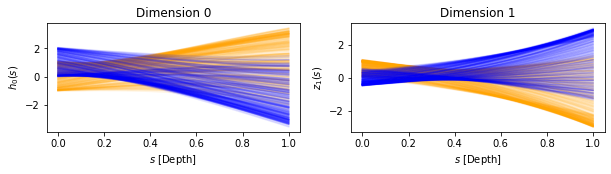

In [114]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(s_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(s_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$s$ [Depth]") ; ax0.set_ylabel(r"$h_0(s)$")
ax1.set_xlabel(r"$s$ [Depth]") ; ax1.set_ylabel(r"$z_1(s)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

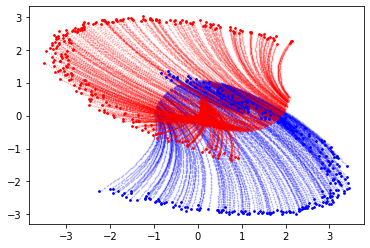

In [115]:
plt.scatter(trajectory[:, yn==0, 0], trajectory[:, yn==0, 1], s=0.6, c='b', alpha=0.2)
plt.scatter(trajectory[:, yn==1, 0], trajectory[:, yn==1, 1], s=0.6, c='r', alpha=0.2)

plt.scatter(trajectory[-1, yn==0, 0], trajectory[-1, yn==0, 1], s=3, c='blue')
plt.scatter(trajectory[-1, yn==1, 0], trajectory[-1, yn==1, 1], s=3, c='red')

In [116]:
from matplotlib import cm

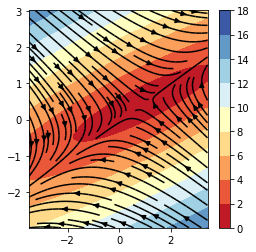

In [117]:
# evaluate vector field
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)

z = model[0](z)
model[1].defunc.f_func[0].u = z.cuda()


f = model[1].f(0, z.to(device)).cpu().detach()

fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
neg = ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
fig.colorbar(neg)

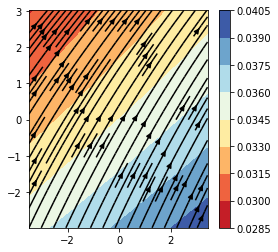

In [118]:
# evaluate vector field
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)

z = model[0](z)
model[1].defunc.g_func[0].u = z.cuda()
f = model[1].g(0, z.to(device)).cpu().detach()
f = f[:, range(f.shape[1]), range(f.shape[1])]

fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
neg = ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')
fig.colorbar(neg)